# Feature & Target Pipeline
Quick smoke test that mirrors production: build features, derive targets, combine them, and prepare time-based splits.

    Basically, we need to understand the likelihood of a massive drop is high and historically it happnes many times a year.
    Based on this, it makes most sense to go long after these drops then to be long and experience a drop and then try to get out in there.
    The problem may be that selling calls/puts puts you into positions you dont want and all of a sudden you are running a large position and market is going against you.
    This size of position, and max risk/pnl loss etc needs to be calculated and adhered to.

    For the drops, we need to look at it like this approx:
    
    For drops between 10-15%: Allocate 10% of your capital.
    For drops between 15-30%: Allocate 25% of your capital.
    For drops between 30-50%: Allocate 35% of your capital.
    For drops greater than 50%: Allocate the remaining 30% of your capital.


In [1]:
import pandas as pd

from data_pipeline import load_data
from featureEngineer import FeatureEngineer
from targetEngineer import ExpirationTargetEngineer
from ML_setup import CONFIG

print("Imports and configuration ready")

# Build features, targets, and combined dataframe
raw_history = load_data(CONFIG["data"]["path"])


history_slice = raw_history[CONFIG["data"]["slice_start"]:CONFIG["data"]["slice_end"]].copy()
history_slice = history_slice.sort_index()

feature_params = dict(CONFIG["features"]["params"])
verbose = feature_params.pop("verbose", False)
feature_engineer = FeatureEngineer(verbose=verbose, **feature_params)
feature_engineer.fit(history_slice)
features = feature_engineer.transform(history_slice)

target_engineer = ExpirationTargetEngineer(**CONFIG["targets"]["params"])
targets = target_engineer.fit_transform(features)
targets = targets.reindex(features.index)

combined_df = features.join(targets, how="inner")
combined_df = combined_df.dropna()

raw_price_cols = [col for col in ("o", "h", "l", "c") if col in features.columns]
if raw_price_cols:
    features = features.drop(columns=raw_price_cols)

features = features.reindex(combined_df.index)
targets = targets.reindex(combined_df.index)

print(f"features shape: {features.shape}")
print(f"targets shape: {targets.shape}")
print(f"combined_df shape: {combined_df.shape}")

# Time-aware train/validation/test split
split_cfg = CONFIG["splitting"]
train_pct = split_cfg["train_pct"]
val_pct = split_cfg["val_pct"]

n_rows = len(combined_df)
train_end = int(n_rows * train_pct)
val_end = train_end + int(n_rows * val_pct)

X_train = features.iloc[:train_end]
X_val = features.iloc[train_end:val_end]
X_test = features.iloc[val_end:]
y_train = targets.iloc[:train_end]
y_val = targets.iloc[train_end:val_end]
y_test = targets.iloc[val_end:]

print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")


df = history_slice.copy()


/home/east/shared/eastSync/pyEast/MLDev/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔍 Scanning for models in: bs_focus/trained_models
📋 Pattern: catboost_*_hpt_bundle.pkl
✅ Found 113 model files
   📦 model_logret_down_1h_p05 -> /shared/eastSync/pyEast/MLDev/bs_focus/trained_models/catboost_logret_down_1h_p05_stage1_hpt_bundle.pkl (stage: stage1)
   📦 model_logret_down_1h_p20 -> /shared/eastSync/pyEast/MLDev/bs_focus/trained_models/catboost_logret_down_1h_p20_stage1_hpt_bundle.pkl (stage: stage1)
   📦 model_logret_up_1h_p25 -> /shared/eastSync/pyEast/MLDev/bs_focus/trained_models/catboost_logret_up_1h_p25_stage1_hpt_bundle.pkl (stage: stage1)
   📦 model_logret_down_1h_p30 -> /shared/eastSync/pyEast/MLDev/bs_focus/trained_models/catboost_logret_down_1h_p30_stage1_hpt_bundle.pkl (stage: stage1)
   📦 model_logret_down_1h_p50 -> /shared/eastSync/pyEast/MLDev/bs_focus/trained_models/catboost_logret_down_1h_p50_stage1_hpt_bundle.pkl (stage: stage1)
   📦 model_logret_up_1h_p50 -> /shared/eastSync/pyEast/MLDev/bs_focus/trained_models/catboost_logret_up_1h_p50_stage1_hpt_bundle

In [3]:
features.columns.tolist()

['volCcy',
 'time_to_exp1_hr',
 'time_elapsed',
 'hour',
 'day_of_week',
 'is_weekend',
 'hour_of_week',
 'hour_of_week_sin',
 'hour_of_week_cos',
 'hours_since_week_start',
 'day_type_num',
 'prev_close',
 'volCcy_prev',
 'window_prev_close',
 'returns_1h',
 'returns_2h',
 'logret_2h',
 'returns_3h',
 'logret_3h',
 'returns_4h',
 'logret_4h',
 'returns_5h',
 'logret_5h',
 'returns_6h',
 'logret_6h',
 'returns_12h',
 'logret_12h',
 'returns_24h',
 'logret_24h',
 'returns_72h',
 'logret_72h',
 'returns_1wk',
 'returns_1M',
 'ret_h_pc',
 'ret_l_pc',
 'ret_c_pc',
 'ret_h_l',
 'range_2h',
 'range_pc_2h',
 'range_3h',
 'range_pc_3h',
 'range_6h',
 'range_pc_6h',
 'range_12h',
 'range_pc_12h',
 'range_24h',
 'range_pc_24h',
 'range',
 'range_pc',
 'close_to_high',
 'close_to_low',
 'close_pos_in_bar',
 'logret_h_pc',
 'logret_l_pc',
 'logret_c_pc',
 'is_dst',
 'tte_phase_cos',
 'tte_phase_sin',
 'momentum_3h',
 'momentum_signed_sqrt_3h',
 'momentum_6h',
 'momentum_signed_sqrt_6h',
 'momentum

In [5]:
targets

,max_p1,min_p1,exp1_max_ret,exp1_min_ret,exp1_peak_frac,exp1_trough_frac,exp1_peak_hours_to_expiry,exp1_trough_hours_to_expiry,exp1_close_ret,abs_max_p1,...,logret_up_1h,logret_down_1h,logret_up_3h,logret_down_3h,logret_up_6h,logret_down_6h,logret_up_12h,logret_down_12h,logret_up_24h,logret_down_24h
2019-10-13 00:00:00,8368.5,8317.8,0.007222,0.001119,0.000000,0.714286,7.0,2.0,0.005079,8430.0,...,0.003807,0.000000,0.003807,0.000000,0.003807,-0.002270,0.014091,-0.002270,0.015662,-0.022650
2019-10-13 01:00:00,8363.4,8317.8,0.003203,-0.002267,0.333333,0.666667,4.0,2.0,0.001679,8430.0,...,0.001041,-0.001186,0.001615,-0.001186,0.001615,-0.003852,0.012508,-0.003852,0.014080,-0.024232
2019-10-13 02:00:00,8363.4,8317.8,0.001617,-0.003844,0.200000,0.600000,4.0,2.0,0.000096,8430.0,...,0.000132,-0.000827,0.001975,-0.002843,0.001975,-0.003492,0.012868,-0.003492,0.014440,-0.023872
2019-10-13 03:00:00,8363.4,8317.8,0.001977,-0.003486,0.000000,0.500000,4.0,2.0,0.000455,8430.0,...,0.002202,-0.000467,0.002202,-0.003265,0.002202,-0.003265,0.013095,-0.003265,0.014667,-0.023645
2019-10-13 04:00:00,8350.0,8317.8,0.000599,-0.003259,0.666667,0.333333,1.0,2.0,0.000683,8430.0,...,0.000000,-0.002220,0.000995,-0.002869,0.002012,-0.002869,0.015063,-0.002869,0.015063,-0.023249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-25 03:00:00,7601.7,7506.0,0.013695,0.000933,0.750000,0.000000,1.0,4.0,0.007854,7621.1,...,0.000452,-0.002953,0.009229,-0.002953,0.009716,-0.002953,0.028469,-0.002953,0.028469,-0.006316
2020-04-25 04:00:00,7601.7,7525.7,0.009763,-0.000332,0.666667,0.000000,1.0,3.0,0.003945,7621.1,...,0.006105,-0.000292,0.009756,-0.000292,0.009756,-0.001915,0.028509,-0.006276,0.028509,-0.006276
2020-04-25 05:00:00,7601.7,7540.0,0.009804,0.001607,0.500000,0.000000,1.0,2.0,0.003985,7621.1,...,0.003177,-0.004486,0.003664,-0.008007,0.005149,-0.008007,0.022417,-0.012368,0.022417,-0.012368
2020-04-25 06:00:00,7601.7,7553.0,0.003671,-0.002759,0.000000,0.000000,1.0,1.0,-0.002113,7621.1,...,0.002054,-0.004373,0.002054,-0.009616,0.003540,-0.009616,0.020807,-0.013978,0.020807,-0.013978


<Axes: >

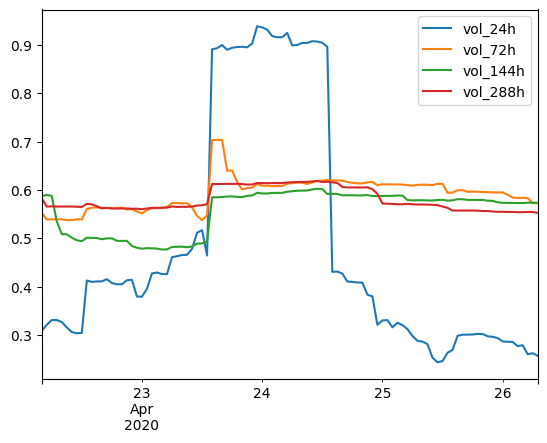

In [8]:



import numpy as np

df['log_ret'] = np.log(df['c'] / df['c'].shift(1))



df['vol_24h'] = df['log_ret'].rolling(window=24).std() * np.sqrt(365*24)
df['vol_72h'] = df['log_ret'].rolling(window=72).std() * np.sqrt(365*24)
df['vol_144h'] = df['log_ret'].rolling(window=144).std() * np.sqrt(365*24)
df['vol_288h'] = df['log_ret'].rolling(window=288).std() * np.sqrt(365*24)

cols = ['vol_24h', 'vol_72h','vol_144h', 'vol_288h']

df[cols][-100:].plot()

# Drawdown landscape overview
We'll summarise peak-to-trough declines and recoveries using percentage-based drawdowns so we can understand typical depth and duration profiles before diving into more granular cases.

1. Compute running maximum and percentage drawdowns on `combined_df['c']`.
2. Segment the series into peak→trough→recovery episodes based on when drawdown drops below zero and later returns to zero.
3. Capture key metrics for each episode (depth %, time to trough, time to recover).
4. Aggregate the episodes to get high-level statistics (median depths, durations, top drawdowns, unresolved drawdowns).